# Deep Deterministic Policy Gradient


## Deep Deterministic Policy Gradient code

In [2]:
# imports
%matplotlib inline

import os, sys
import gym
from parameters import parse_args
from ddpg import DDPG
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import time
import numpy as np
from utils import Viewer

Networks initialized
INFO:tensorflow:Restoring parameters from Trainings/MountainCarContinuous-v0/03012018/model.ckpt
Networks loaded


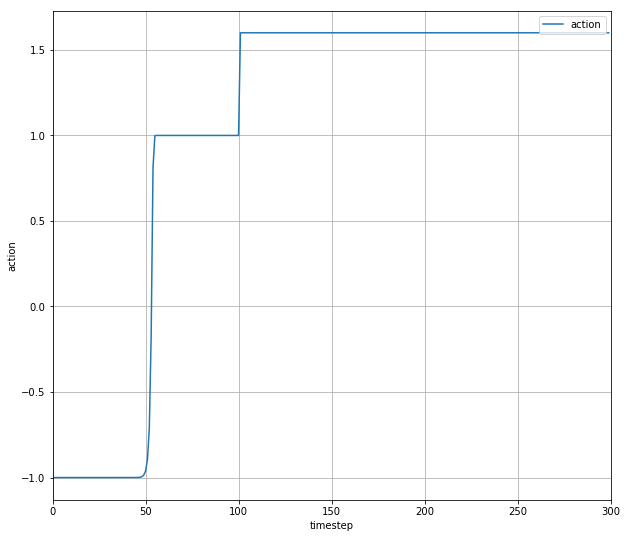

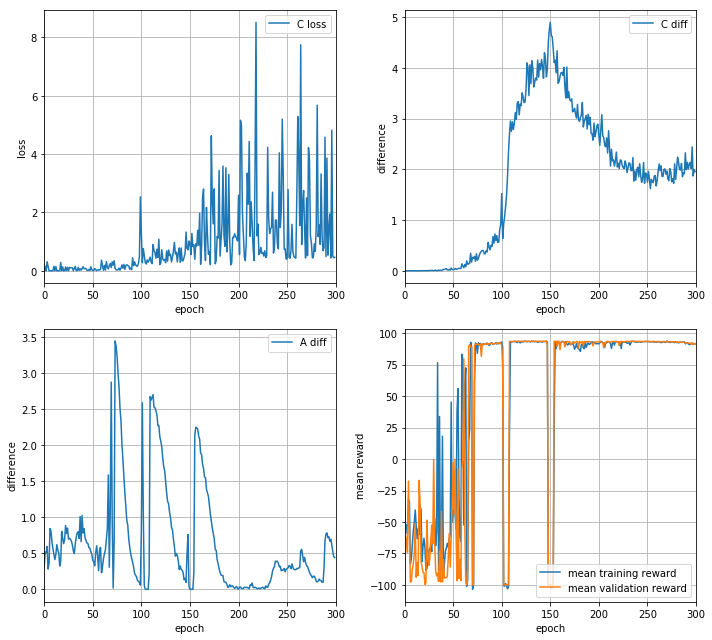

In [14]:
agent_params, dppg_params, cnn_params, a_params, c_params = parse_args()

# Change here depending on what environment you want to test
agent_params['environment'] = "MountainCarContinuous-v0"
# agent_params['environment'] = "Pendulum-v0"

env = gym.make(agent_params['environment'])
action_frames = agent_params['action_frames']
steps = agent_params['steps']
if steps > env.spec.timestep_limit:
    steps = env.spec.timestep_limit
action_shape = env.action_space.shape
action_bound = env.action_space.high
observation_shape = env.observation_space.shape
tf.reset_default_graph()

actions = []
with tf.Session() as session:
    ddpg = DDPG(action_shape, action_bound, observation_shape, dppg_params, cnn_params, a_params, c_params, session)
    saver = tf.train.Saver()
    ddpg.load(saver, agent_params['environment'], "03012018")
    env.seed(300)
    reward_sum_v = 0
    observation = env.reset()
    frames = action_frames
    for i in range(300):
        env.render()
        if frames == action_frames:
            action = ddpg.select_action([observation], stochastic = False, target = False, step = i)[0] 
            if i > 100:
                action += 0.6
            frames = 0
        observation, reward, done, _ = env.step(action)
        actions.append(action)
        frames += 1
        if frames == action_frames: 
            reward_sum_v += reward
        if done: 
            if frames != action_frames:
                reward_sum_v += reward
                #        break    

plt.figure(figsize=(10,9))
plt.plot(actions, label='action')
plt.xlabel('timestep'); plt.ylabel('action')
plt.xlim((0, len(actions)))
plt.legend(loc=1); plt.grid()

with open("Trainings/" + agent_params['environment'] + "/" + time.strftime("%d%m%Y") + "/statistics.txt", "rb") as fp:   # Unpickling
    statistics = pickle.load(fp)

statistics = np.array(statistics).T
mean_training_rewards = statistics[0]
mean_validation_rewards = statistics[1]
C_losses = statistics[2]
C_diffs = statistics[3]
A_diffs = statistics[4]

plt.figure(figsize=(10,9))

plt.subplot(221)
# Plots the loss for the critic network
plt.plot(C_losses, label='C loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.xlim((0, len(C_losses)))
plt.legend(loc=1); plt.grid()

plt.subplot(222)
# Plots the difference between the target and "true" critic networks
plt.plot(C_diffs, label='C diff')
plt.xlabel('epoch'); plt.ylabel('difference')
plt.xlim((0, len(C_diffs)))
plt.legend(loc=1); plt.grid()

plt.subplot(223)
# Plots the difference between the target and "true" actor networks
plt.plot(A_diffs, label='A diff')
plt.xlabel('epoch'); plt.ylabel('difference')
plt.xlim((0, len(A_diffs)))
plt.legend(loc=1); plt.grid()

plt.subplot(224)
# Plots the mean training and validation rewards
plt.plot(mean_training_rewards, label='mean training reward')
plt.plot(mean_validation_rewards, label='mean validation reward')
plt.xlabel('epoch'); plt.ylabel('mean reward')
plt.xlim((0, len(mean_validation_rewards)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

